In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from collections import OrderedDict
from tqdm import tqdm
import datetime

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_sizes

{'train': 4560, 'val': 385}

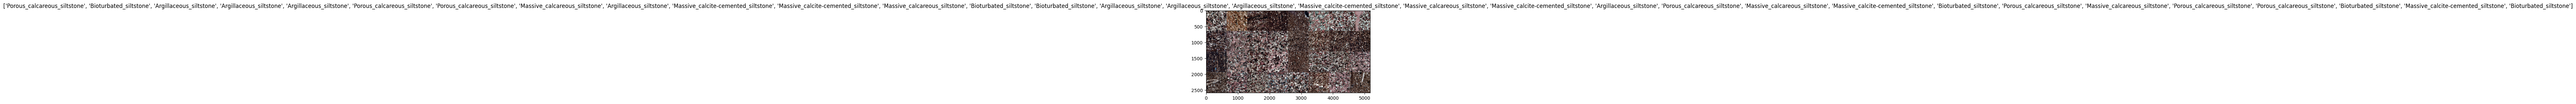

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            print(datetime.datetime.now())

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
class SKAttention(nn.Module):
    def __init__(self, channel=512, kernels=[1, 3, 5, 7], reduction=16, group=1, L=32):
        super().__init__()
        self.d = max(L, channel // reduction)
        self.convs = nn.ModuleList([])
        for k in kernels:
            self.convs.append(
                nn.Sequential(OrderedDict([
                    ('conv', nn.Conv2d(channel, channel, kernel_size=k, padding=k // 2, groups=group)),
                    ('bn', nn.BatchNorm2d(channel)),
                    ('relu', nn.ReLU())
                ]))
            )
        self.fc = nn.Linear(channel, self.d)
        self.fcs = nn.ModuleList([])
        for i in range(len(kernels)):
            self.fcs.append(nn.Linear(self.d, channel))
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        bs, c, _, _ = x.size()
        conv_outs = []
        ### split
        for conv in self.convs:
            conv_outs.append(conv(x))
        feats = torch.stack(conv_outs, 0)  # k,bs,channel,h,w

        ### fuse
        U = sum(conv_outs)  # bs,c,h,w

        ### reduction channel
        S = U.mean(-1).mean(-1)  # bs,c
        Z = self.fc(S)  # bs,d

        ### calculate attention weight
        weights = []
        for fc in self.fcs:
            weight = fc(Z)
            weights.append(weight.view(bs, c, 1, 1))  # bs,channel
        attention_weughts = torch.stack(weights, 0)  # k,bs,channel,1,1
        attention_weughts = self.softmax(attention_weughts)  # k,bs,channel,1,1

        ### fuse
        V = (attention_weughts * feats).sum(0)
        return V

In [7]:
model_ft = models.mobilenet_v3_large(weights='IMAGENET1K_V2', pretrained=True)
num_ftrs = model_ft.classifier[3].out_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine

In [9]:
model_ft

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
#for name, param in model_ft.named_parameters():
#    param.requires_grad = False

In [11]:
#model_ft.features[4].block[2] = SKAttention(channel=72, reduction=8)
#model_ft.features[5].block[2] = SKAttention(channel=120, reduction=8)
#model_ft.features[6].block[2] = SKAttention(channel=120, reduction=8)
#model_ft.features[11].block[2] = SKAttention(channel=480, reduction=8)
#model_ft.features[12].block[2] = SKAttention(channel=672, reduction=8)
#model_ft.features[13].block[2] = SKAttention(channel=672, reduction=8)
model_ft.features[14].block[2] = SKAttention(channel=960, reduction=8)
model_ft.features[15].block[2] = SKAttention(channel=960, reduction=8)

In [12]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print(f"{name} will be updated.")
    else:
        print(f"{name} will not be updated.")

features.0.0.weight will be updated.
features.0.1.weight will be updated.
features.0.1.bias will be updated.
features.1.block.0.0.weight will be updated.
features.1.block.0.1.weight will be updated.
features.1.block.0.1.bias will be updated.
features.1.block.1.0.weight will be updated.
features.1.block.1.1.weight will be updated.
features.1.block.1.1.bias will be updated.
features.2.block.0.0.weight will be updated.
features.2.block.0.1.weight will be updated.
features.2.block.0.1.bias will be updated.
features.2.block.1.0.weight will be updated.
features.2.block.1.1.weight will be updated.
features.2.block.1.1.bias will be updated.
features.2.block.2.0.weight will be updated.
features.2.block.2.1.weight will be updated.
features.2.block.2.1.bias will be updated.
features.3.block.0.0.weight will be updated.
features.3.block.0.1.weight will be updated.
features.3.block.0.1.bias will be updated.
features.3.block.1.0.weight will be updated.
features.3.block.1.1.weight will be updated.
fea

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
2024-09-11 08:34:47.258778


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:38:09<00:00, 41.18s/it]


train Loss: 0.7255 Acc: 0.8208


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:47<00:00, 12.89s/it]


val Loss: 0.4436 Acc: 0.9143

Epoch 1/29
----------
2024-09-11 10:15:49.176898


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:41:00<00:00, 42.38s/it]


train Loss: 0.0740 Acc: 0.9728


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:46<00:00, 12.81s/it]


val Loss: 0.2904 Acc: 0.9065

Epoch 2/29
----------
2024-09-11 11:59:36.268491


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:20<00:00, 40.00s/it]


train Loss: 0.0324 Acc: 0.9904


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:40<00:00, 12.34s/it]


val Loss: 0.1767 Acc: 0.9662

Epoch 3/29
----------
2024-09-11 13:37:42.332238


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:32:58<00:00, 39.01s/it]


train Loss: 0.0220 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:26<00:00, 11.27s/it]


val Loss: 0.1339 Acc: 0.9532

Epoch 4/29
----------
2024-09-11 15:13:06.875913


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:02<00:00, 39.04s/it]


train Loss: 0.0074 Acc: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:38<00:00, 12.18s/it]


val Loss: 0.1712 Acc: 0.9455

Epoch 5/29
----------
2024-09-11 16:48:47.799340


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:44<00:00, 39.33s/it]


train Loss: 0.0142 Acc: 0.9963


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:46<00:00, 12.80s/it]


val Loss: 0.2144 Acc: 0.9299

Epoch 6/29
----------
2024-09-11 18:25:18.224314


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:38:16<00:00, 41.23s/it]


train Loss: 0.0091 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:44<00:00, 12.66s/it]


val Loss: 0.1779 Acc: 0.9714

Epoch 7/29
----------
2024-09-11 20:06:24.501967


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:24<00:00, 39.61s/it]


train Loss: 0.0046 Acc: 0.9985


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:45<00:00, 12.69s/it]


val Loss: 0.1491 Acc: 0.9688

Epoch 8/29
----------
2024-09-11 21:43:34.391954


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:13<00:00, 39.54s/it]


train Loss: 0.0029 Acc: 0.9991


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:30<00:00, 11.60s/it]


val Loss: 0.1536 Acc: 0.9688

Epoch 9/29
----------
2024-09-11 23:20:18.869059


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:09<00:00, 39.51s/it]


train Loss: 0.0021 Acc: 0.9993


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:24<00:00, 11.11s/it]


val Loss: 0.1615 Acc: 0.9688

Epoch 10/29
----------
2024-09-12 00:56:52.900507


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:40:36<00:00, 42.21s/it]


train Loss: 0.0026 Acc: 0.9993


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:42<00:00, 12.50s/it]


val Loss: 0.1569 Acc: 0.9636

Epoch 11/29
----------
2024-09-12 02:40:11.614146


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:51<00:00, 41.90s/it]


train Loss: 0.0013 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:36<00:00, 12.03s/it]


val Loss: 0.1498 Acc: 0.9636

Epoch 12/29
----------
2024-09-12 04:22:39.913458


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:33:38<00:00, 39.29s/it]


train Loss: 0.0010 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:28<00:00, 11.41s/it]


val Loss: 0.1512 Acc: 0.9610

Epoch 13/29
----------
2024-09-12 05:58:46.817772


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:38:19<00:00, 41.26s/it]


train Loss: 0.0020 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:24<00:00, 11.11s/it]


val Loss: 0.1485 Acc: 0.9662

Epoch 14/29
----------
2024-09-12 07:39:31.074190


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:40:15<00:00, 42.07s/it]


train Loss: 0.0013 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:48<00:00, 12.96s/it]


val Loss: 0.1484 Acc: 0.9662

Epoch 15/29
----------
2024-09-12 09:22:35.447600


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:42:35<00:00, 43.04s/it]


train Loss: 0.0018 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:50<00:00, 13.10s/it]


val Loss: 0.1459 Acc: 0.9662

Epoch 16/29
----------
2024-09-12 11:08:01.000835


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:44:18<00:00, 43.76s/it]


train Loss: 0.0016 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:44<00:00, 12.63s/it]


val Loss: 0.1477 Acc: 0.9662

Epoch 17/29
----------
2024-09-12 12:55:03.290522


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:13<00:00, 41.64s/it]


train Loss: 0.0013 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:45<00:00, 12.75s/it]


val Loss: 0.1444 Acc: 0.9662

Epoch 18/29
----------
2024-09-12 14:37:02.978506


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:07<00:00, 41.59s/it]


train Loss: 0.0012 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:43<00:00, 12.54s/it]


val Loss: 0.1450 Acc: 0.9662

Epoch 19/29
----------
2024-09-12 16:18:53.753003


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:40:23<00:00, 42.12s/it]


train Loss: 0.0018 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:28<00:00, 11.44s/it]


val Loss: 0.1463 Acc: 0.9662

Epoch 20/29
----------
2024-09-12 18:01:45.517728


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:39:22<00:00, 41.69s/it]


train Loss: 0.0014 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:32<00:00, 11.73s/it]


val Loss: 0.1427 Acc: 0.9662

Epoch 21/29
----------
2024-09-12 19:43:40.110818


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:05<00:00, 40.32s/it]


train Loss: 0.0007 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:37<00:00, 12.09s/it]


val Loss: 0.1418 Acc: 0.9662

Epoch 22/29
----------
2024-09-12 21:22:23.085019


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:12<00:00, 39.95s/it]


train Loss: 0.0023 Acc: 0.9996


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:46<00:00, 12.81s/it]


val Loss: 0.1444 Acc: 0.9662

Epoch 23/29
----------
2024-09-12 23:00:22.069174


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:35:33<00:00, 40.09s/it]


train Loss: 0.0009 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:28<00:00, 11.40s/it]


val Loss: 0.1442 Acc: 0.9662

Epoch 24/29
----------
2024-09-13 00:38:23.615742


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:40:00<00:00, 41.96s/it]


train Loss: 0.0012 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:44<00:00, 12.62s/it]


val Loss: 0.1443 Acc: 0.9662

Epoch 25/29
----------
2024-09-13 02:21:07.772244


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:13<00:00, 40.38s/it]


train Loss: 0.0016 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:53<00:00, 13.38s/it]


val Loss: 0.1435 Acc: 0.9662

Epoch 26/29
----------
2024-09-13 04:00:15.608139


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:34:20<00:00, 39.58s/it]


train Loss: 0.0016 Acc: 0.9998


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:41<00:00, 12.45s/it]


val Loss: 0.1445 Acc: 0.9662

Epoch 27/29
----------
2024-09-13 05:37:18.086443


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:39<00:00, 40.55s/it]


train Loss: 0.0011 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:39<00:00, 12.28s/it]


val Loss: 0.1439 Acc: 0.9688

Epoch 28/29
----------
2024-09-13 07:16:37.116955


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:36:27<00:00, 40.47s/it]


train Loss: 0.0013 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:50<00:00, 13.10s/it]


val Loss: 0.1450 Acc: 0.9688

Epoch 29/29
----------
2024-09-13 08:55:54.817139


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [1:42:18<00:00, 42.93s/it]


train Loss: 0.0012 Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:46<00:00, 12.84s/it]


val Loss: 0.1444 Acc: 0.9688

Training complete in 3006m 18s
Best val Acc: 0.971429


In [14]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(644),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'D:/Data'
test_ds = {x: datasets.ImageFolder(os.path.join(data_dir, x), test_transforms[x])
                  for x in ['test']}
test_dataloader = {x: torch.utils.data.DataLoader(test_ds[x], batch_size=4,
                                             shuffle=False, num_workers=4) for x in ['test']}

def test_model(model, loss_fn, dataloader):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(test_ds['test'])
    correct = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in test_dataloader['test']:
            X= X.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == y.data)

    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")

test_model(model_ft, criterion, test_dataloader)

Test Error: 
 Accuracy: 96.3%
